In [96]:
import numpy as np
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import os
import importlib
importlib.reload(pyuvdata)
from IPython.display import Image
from newcal import caldata, calibration_wrappers, calibration_optimization, cost_function_calculations


In [2]:
importlib.reload(caldata)
importlib.reload(calibration_wrappers)

<module 'newcal.calibration_wrappers' from '/usr/local/miniconda3/envs/py310/lib/python3.10/site-packages/newcal/calibration_wrappers.py'>

In [3]:
import plot_delay_spectra
importlib.reload(plot_delay_spectra)

<module 'plot_delay_spectra' from '/home/rbyrne/rlb_hera/plot_delay_spectra.py'>

In [4]:
data_orig = pyuvdata.UVData()
data_orig.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
# model = pyuvdata.UVData()
# model.read("/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.52096.sum.abs_calibrated.red_avg_model.uvfits")
data_abscal = pyuvdata.UVData()
data_abscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_abscal.uvfits"
)
data_dwabscal = pyuvdata.UVData()
data_dwabscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_dwabscal_maxiter2.uvfits"
)
# data.read("/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.16911.uvh5")

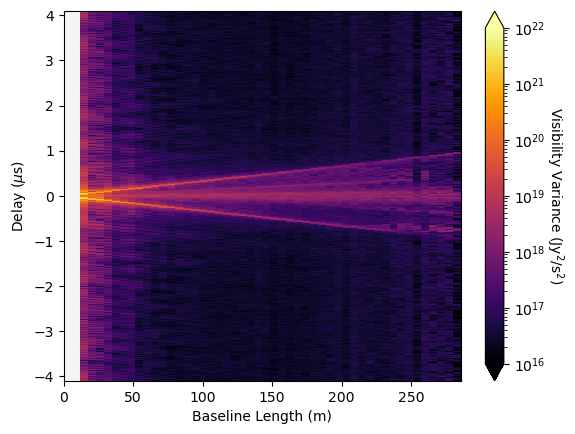

In [5]:
plot_delay_spectra.plot_visibilities(data_orig)

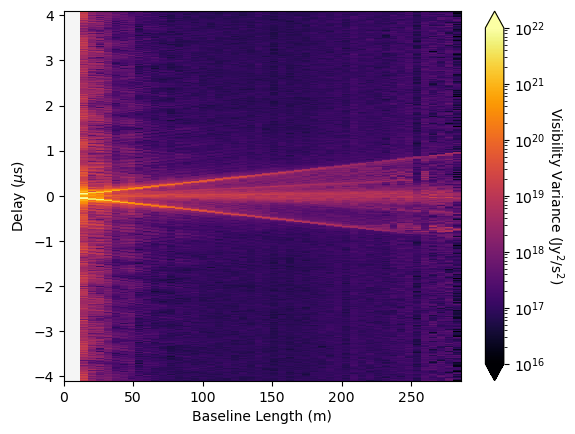

In [6]:
plot_delay_spectra.plot_visibilities(data_abscal)

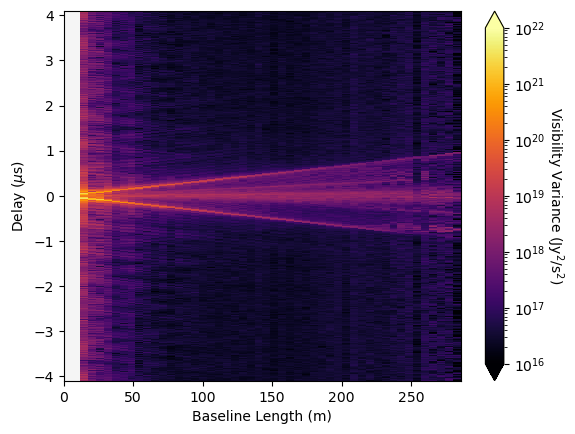

In [7]:
plot_delay_spectra.plot_visibilities(data_dwabscal)

In [8]:
# Normalize data
bl_bin_edges = np.linspace(0, 300, num=51)
delay_spectrum_dwabscal = plot_delay_spectra.calculate_delay_spectra(
    data_dwabscal, bl_bin_edges, use_polarization=-5
)
delay_spectrum_abscal = plot_delay_spectra.calculate_delay_spectra(
    data_abscal, bl_bin_edges, use_polarization=-5
)
data_dwabscal_normalized = data_dwabscal.copy()
print(np.nanmean(delay_spectrum_abscal))
print(np.nanmean(delay_spectrum_dwabscal))
data_dwabscal_normalized.data_array *= np.sqrt(np.nanmean(delay_spectrum_abscal) / np.nanmean(
    delay_spectrum_dwabscal
))

5.100236616496848e+18
1.621054322065453e+18


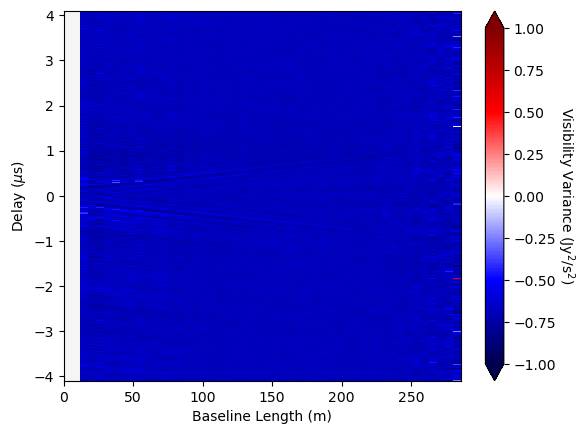

In [9]:
plot_delay_spectra.plot_difference(data_dwabscal, data_abscal, ratio=True)

In [88]:
dwabscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_dwabscal_recalibrated_params.npy"
)
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_abscal_params.npy"
)

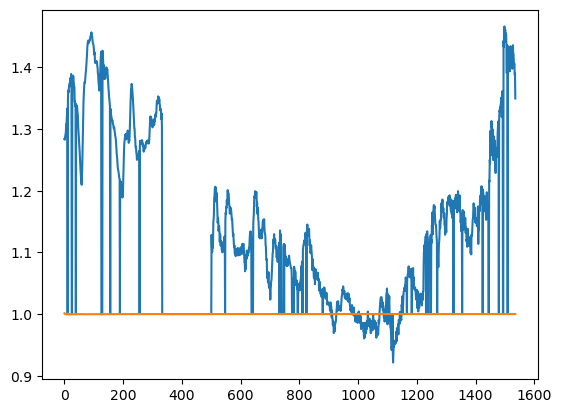

In [89]:
plt.plot(abscal_params[0,:,0])
plt.plot(dwabscal_params[0, :, 0])
#plt.ylim([0,1.3])
plt.show()

In [13]:
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal/zen.2459861.48181.sum.abs_calibrated.red_avg_abscal_params.npy"
)

In [14]:
np.shape(abscal_params)

(3, 1536, 2)

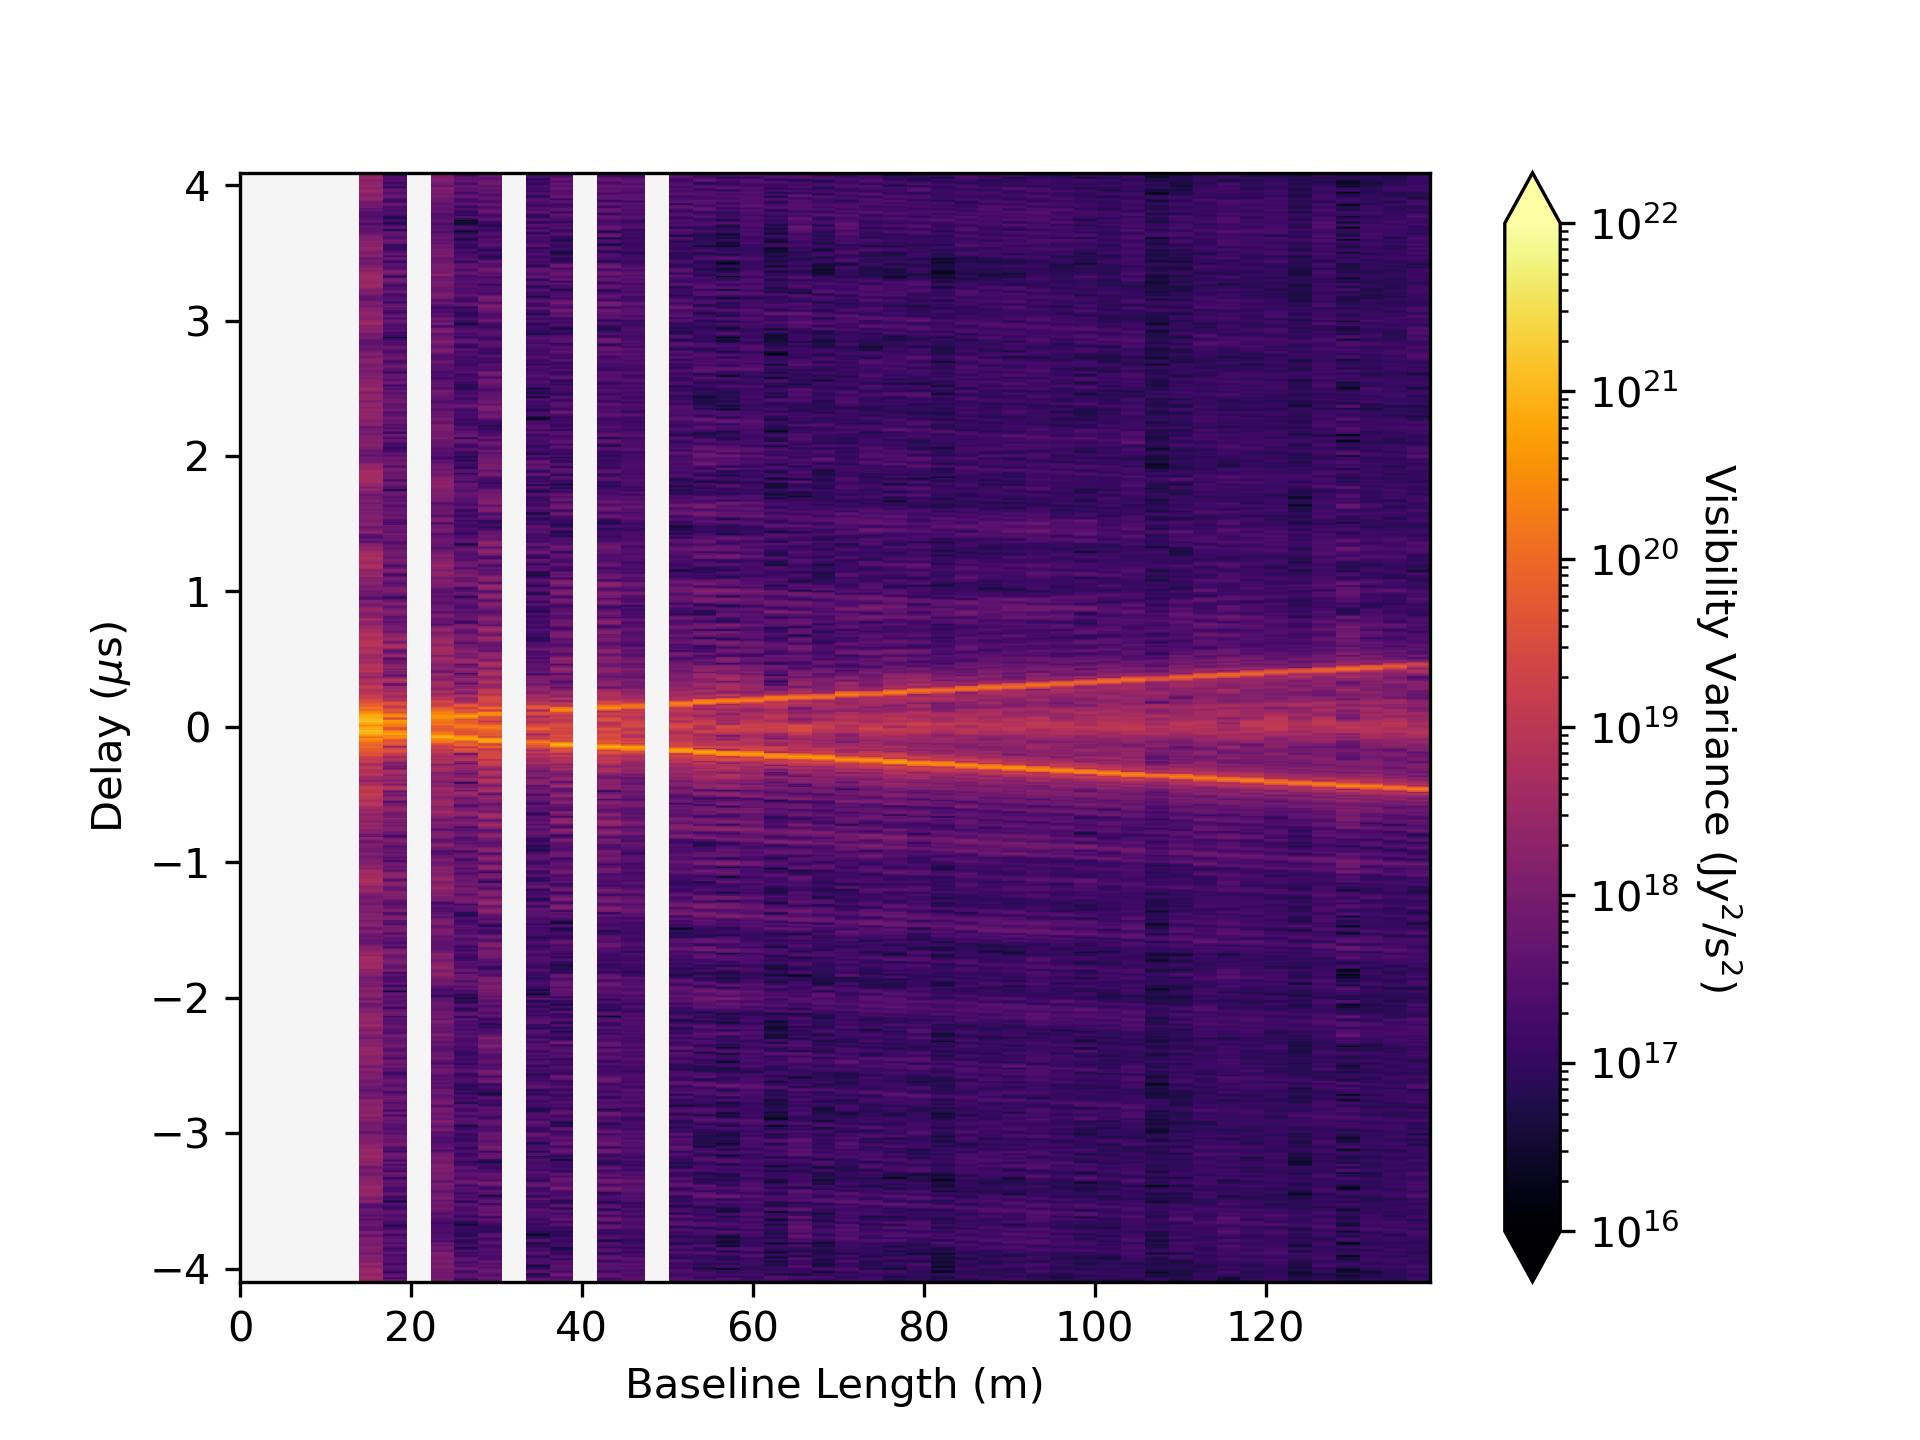

In [15]:
from IPython.display import Image
Image(
    filename="/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_diff.png"
)

In [16]:
cov_mat = np.load("/safepool/rbyrne/hera_abscal_Jun2024/dwcal_cov_matrix.npy")

In [17]:
np.shape(cov_mat)

(2, 417, 1536, 1536, 1)

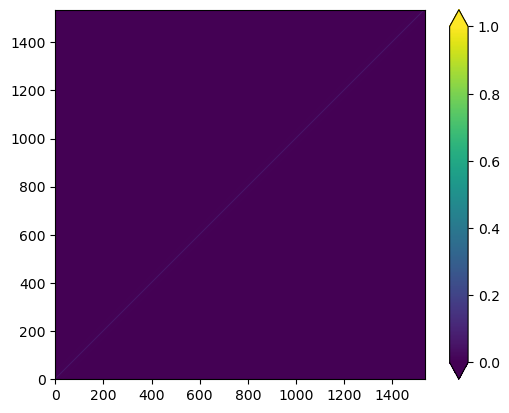

In [18]:
plt.imshow(np.abs(cov_mat[0,1,:,:,0]), interpolation=None, origin="lower", vmin=0, vmax=1)
cbar = plt.colorbar(extend="both")

In [19]:
np.where(np.abs(cov_mat) == np.max(np.abs(cov_mat)))

(array([1, 1, 1, ..., 1, 1, 1]),
 array([ 17,  17,  17, ..., 342, 342, 342]),
 array([   0,    1,    2, ..., 1533, 1534, 1535]),
 array([   0,    1,    2, ..., 1533, 1534, 1535]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [20]:
np.max(np.abs(cov_mat - np.conj(np.transpose(cov_mat, axes=(0,1,3,2,4)))))

0.0

In [21]:
data_path = f"/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
model_path = f"/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
data = pyuvdata.UVData()
data.read(data_path)
model = pyuvdata.UVData()
model.read(model_path)

data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

# Model does not include all baselines
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
use_polarizations = -5
data.select(bls=use_baselines, polarizations=use_polarizations)
model.select(bls=use_baselines, polarizations=use_polarizations)

# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

data.compress_by_redundancy()
model.compress_by_redundancy()

Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.


In [79]:
caldata_obj = caldata.CalData()
caldata_obj.load_data(
    data,
    model,
    #data,
)

divide by zero encountered in divide


In [80]:
caldata_obj.dwcal_inv_covariance = np.zeros((
    caldata_obj.Ntimes,
    caldata_obj.Nbls,
    caldata_obj.Nfreqs,
    caldata_obj.Nfreqs,
    caldata_obj.N_vis_pols,
), dtype=complex)
for freq_ind in range(caldata_obj.Nfreqs):
    caldata_obj.dwcal_inv_covariance[:, :, freq_ind, freq_ind, :] = 1.0 + 1j * 0.0

In [43]:
np.shape(caldata_obj.abscal_params)

(3, 1536, 1)

In [44]:
hess = calibration_optimization.hessian_dw_abscal_wrapper(
    caldata_obj.abscal_params.flatten(), range(caldata_obj.Nfreqs), caldata_obj
)

In [56]:
jac = calibration_optimization.jacobian_dw_abscal_wrapper(
    caldata_obj.abscal_params.flatten(), range(caldata_obj.Nfreqs), caldata_obj
)

In [59]:
print(np.min(jac))

0.0


In [64]:
(
    hess_amp_amp,
    hess_amp_phasex,
    hess_amp_phasey,
    hess_phasex_phasex,
    hess_phasey_phasey,
    hess_phasex_phasey,
) = cost_function_calculations.hess_dw_abscal(
    caldata_obj.abscal_params[0, :, 0],
    caldata_obj.abscal_params[1:, :, 0],
    caldata_obj.model_visibilities[:, :, :, 0],
    caldata_obj.data_visibilities[:, :, :, 0],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, 0],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, 0],
)

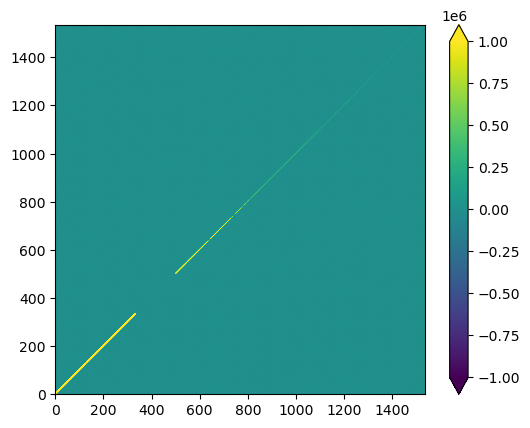

In [65]:
plt.imshow(hess_amp_amp, interpolation=None, origin="lower", vmin=-1e6, vmax=1e6)
cbar = plt.colorbar(extend="both")

In [90]:
plt.plot(np.diag(hess_amp_amp))
plt.ylim([0, 1e9])

ValueError: Input must be 1- or 2-d.

In [67]:
hess_amp_amp_simple_abscal = np.zeros(caldata_obj.Nfreqs)
for freq_ind in range(caldata_obj.Nfreqs):
    (
        hess_amp_amp,
        hess_amp_phasex,
        hess_amp_phasey,
        hess_phasex_phasex,
        hess_phasey_phasey,
        hess_phasex_phasey,
    ) = cost_function_calculations.hess_abs_cal(
        caldata_obj.abscal_params[0, freq_ind, 0],
        caldata_obj.abscal_params[1:, freq_ind, 0],
        caldata_obj.model_visibilities[:, :, freq_ind, 0],
        caldata_obj.data_visibilities[:, :, freq_ind, 0],
        caldata_obj.uv_array,
        caldata_obj.visibility_weights[:, :, freq_ind, 0],
    )
    hess_amp_amp_simple_abscal[freq_ind] = hess_amp_amp

(0.0, 100000000.0)

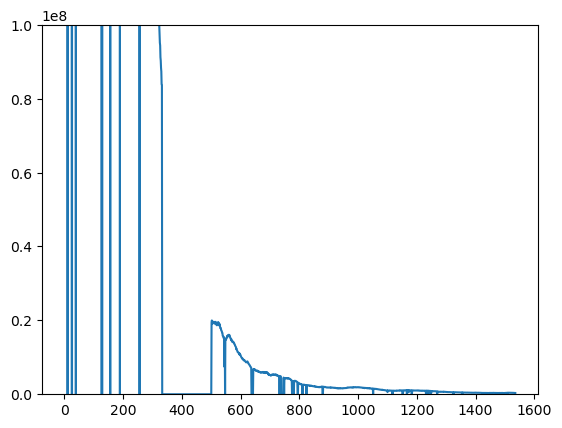

In [95]:
plt.plot(hess_amp_amp_simple_abscal)
plt.ylim([0,1e8])

(0.0, 10000000.0)

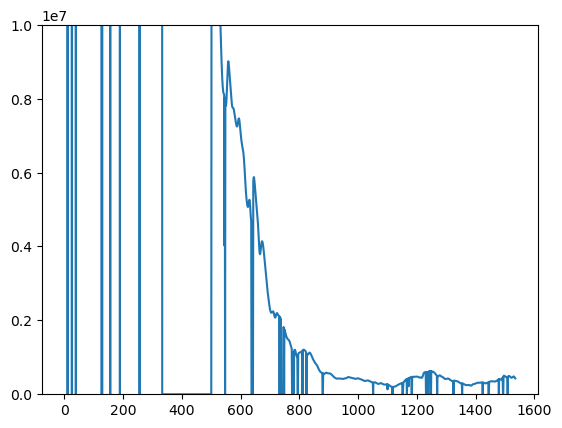

In [85]:
plt.plot(np.sum(np.abs(caldata_obj.visibility_weights*caldata_obj.model_visibilities)**2., axis=(0, 1, 3)))
plt.ylim([0,1e7])

-1089881666.648734
1941778020126.6343


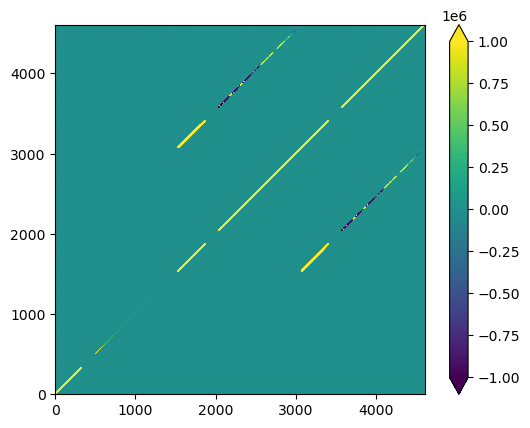

In [45]:
print(np.min(hess))
print(np.max(hess))
plt.imshow(hess, interpolation=None, origin="lower", vmin=-1e6, vmax=1e6)
cbar = plt.colorbar(extend="both")

In [98]:
avg_spectra = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/mean_variance_abscal_nbins200_xx.npz"
)
delay_spectrum_variance = avg_spectra["variance"]
bl_length_bin_edges = avg_spectra["bl_bin_edges"]
delay_axis = avg_spectra["delay_array"]

calibration_wrappers.get_dwcal_weights_from_delay_spectra(
    caldata_obj,
    delay_spectrum_variance,
    bl_length_bin_edges,
    delay_axis,
)

In [47]:
np.shape(caldata_obj.dwcal_inv_covariance)

(2, 417, 1536, 1536, 1)

In [48]:
np.mean(np.diagonal(caldata_obj.dwcal_inv_covariance[0,:,:,:,0],axis1=1,axis2=2))

(1.0071513021687715+0j)

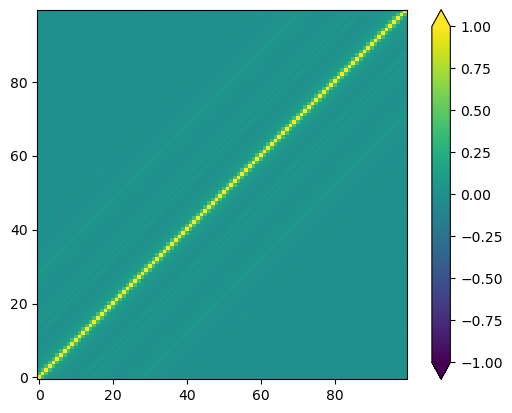

In [101]:
plt.imshow(
    np.abs(caldata_obj.dwcal_inv_covariance[0, 5, 0:100, 0:100, 0]), interpolation=None, origin="lower", vmin=-1, vmax=1
)
cbar = plt.colorbar(extend="both")

In [50]:
hess_weighted = calibration_optimization.hessian_dw_abscal_wrapper(
    caldata_obj.abscal_params.flatten(), range(caldata_obj.Nfreqs), caldata_obj
)

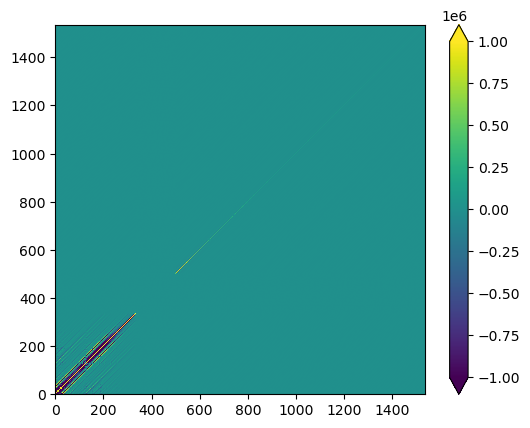

In [51]:
plt.imshow(
    hess_weighted[0:1536, 0:1536],
    interpolation=None,
    origin="lower",
    vmin=-1e6,
    vmax=1e6,
)
cbar = plt.colorbar(extend="both")

In [52]:
np.shape(caldata_obj.abscal_params)

(3, 1536, 1)

In [53]:
(
    hess_amp_amp,
    hess_amp_phasex,
    hess_amp_phasey,
    hess_phasex_phasex,
    hess_phasey_phasey,
    hess_phasex_phasey,
) = cost_function_calculations.hess_dw_abscal(
    caldata_obj.abscal_params[0, :, 0],
    caldata_obj.abscal_params[1:, :, 0],
    caldata_obj.model_visibilities[:, :, :, 0],
    caldata_obj.data_visibilities[:, :, :, 0],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, 0],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, 0],
)

KeyboardInterrupt: 

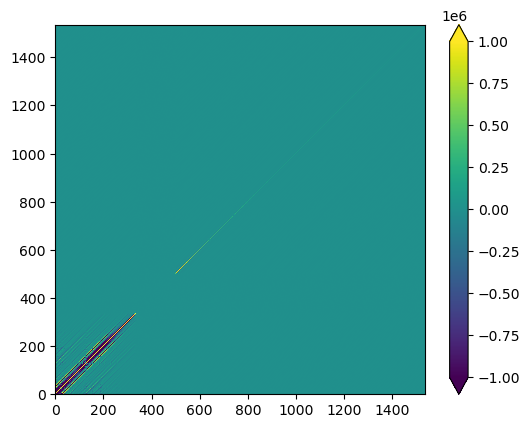

In [ ]:
plt.imshow(hess_amp_amp, interpolation=None, origin="lower", vmin=-1e6, vmax=1e6)
cbar = plt.colorbar(extend="both")

In [ ]:
np.shape(hess_amp_amp)

(1536, 1536)